# 7.2 Group Invariance (Qualitative)

## Measurement Invariance across groups for qualitative item responses

In [1]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Rpy2 imports
from rpy2 import robjects as ro
from rpy2.robjects import pandas2ri, numpy2ri
from rpy2.robjects.packages import importr

# Automatic conversion of arrays and dataframes
pandas2ri.activate()
numpy2ri.activate()

# Set random seed for reproducibility
ro.r('set.seed(123)')

# Ipython extenrsion for magix plotting
%load_ext rpy2.ipython

# R imports
importr('base')
importr('lavaan')
importr('semTools')
importr('MPsychoR')
importr('lordif')
importr('Hmisc')

c:\Users\maku1542\AppData\Local\miniconda3\envs\psy126\Lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


rpy2.robjects.packages.Package as a <module 'Hmisc'>

Measurement invariance can also be tested for dichotomous or polytomous (i.e. qualitative) item responses. In the Item Response Theory (IRT) this is known as **Differential Item Functioning (DIF)**. We can distinguish between two forms of DIF:  

* **Uniform DIF:** the ICCs are shifted in location across subgroups, but they remain
parallel (i.e., a group main effect)
* **Nonuniform DIF:** the ICCs across subgroups are shifted, and they cross (i.e., an
interaction effect between group and the trait)  

We focus on DIF detection using logistic regression (we skip tree-based DIF assessment as it was not covered in the statistics lecture yet).  

The idea of this approach (Zumbo, 1999) is to specify a set of logistic regression equations and predict the original item responses from the person parameters $\theta$ and the external grouping variable $z$. The following set of proportional odds models is formulated (Choi et al., 2011):  

* $M_1$ : $logit(P(x_i)) = \tau_0 + \tau_1\theta$
* $M_2$ : $logit(P(x_i)) = \tau_0 + \tau_1\theta + \tau_2z$
* $M_3$ : $logit(P(x_i)) = \tau_0 + \tau_1\theta + \tau_2z + \tau_3\theta z$

We are interested in comparing the following models via the **LR-principle**:

* $M_2$ vs. $M_1$: if significant, we have **uniform** DIF.
* $M_3$ vs. $M_2$: if significant, we have **nonuniform** DIF.

### Load, prepare and inspect the dataset

We load and inspect the dataset. It's called `YouthDep`. Extract the first 26 items and store the result in `cdi`. Also inspect your newly created subset.

In [2]:
ro.r('data("YouthDep")')                                    # Load the YouthDep dataset from R          
YouthDep_df = pandas2ri.rpy2py(ro.globalenv['YouthDep'])    # Convert to Python
cdi = YouthDep_df.iloc[:, :26]                              # Select first 26 columns
print(cdi.head())

# Put data back into R
ro.globalenv['cdi'] = cdi

   CDI1  CDI2r  CDI3  CDI4  CDI5r  CDI6  CDI7r  CDI8r  CDI10r  CDI11r  ...  \
1     1      1     1     1      1     1      1      1       1       1  ...   
2     1      1     1     1      1     1      1      1       1       1  ...   
3     1      1     1     1      1     2      1      1       1       1  ...   
4     1      1     1     1      1     1      1      2       1       1  ...   
5     1      1     1     2      1     2      2      1       1       2  ...   

   CDI18r  CDI19  CDI20  CDI21r  CDI22  CDI23  CDI24r  CDI25r  CDI26  CDI27  
1       1      1      2       2      1      1       1       1      2      1  
2       1      1      1       1      1      1       1       1      1      1  
3       1      1      1       1      1      1       1       1      1      1  
4       1      1      1       1      1      2       2       1      1      1  
5       1      1      1       1      2      1       3       1      1      1  

[5 rows x 26 columns]


#### The dataset

As an example, we use a dataset from Vaughn-Coaxum et al. (2016) on youth
depression. The 26 items come from the Children’s Depression Inventory (CDI);
each item is scored on a scale from 0 to 2. The authors were interested in DIF
analyses on an external race variable (four categories). Note that the aim was
not to eliminate items from the CDI, which is a well-established scale. Rather,
the authors wanted to identify DIF items (which already gives useful substantive
information) and score all individuals in a “fair” way by means of group-specific
person parameter estimates for items flagged as DIF.

### Fit the models

Use the `lordif` function to fit the models (with this one function you will fit all the models described above). We want to use `YouthDep$race` as our grouping variable and our `cdi` subset as the dataset.

In [3]:
ro.r('cdiDIF <- lordif(cdi, YouthDep$race, criterion = "Chisqr")')

 (mirt) | Iteration: 1, 21 items flagged for DIF (1,2,4,5,6,7,9,10,11,13,14,15,16,17,18,20,22,23,24,25,26)
 (mirt) | Iteration: 2, 20 items flagged for DIF (2,3,4,5,6,7,8,10,11,13,14,16,17,18,20,22,23,24,25,26)
 (mirt) | Iteration: 3, 20 items flagged for DIF (2,3,4,5,6,7,8,10,11,13,14,16,17,18,20,22,23,24,25,26)


In total, 20 out of 26 items are flagged as DIF. Let us print out the p-values of
the LR-tests for the first three items:

In [4]:
print(ro.r("cdiDIF$stats[1:3, 1:5]"))

  item ncat chi12  chi13  chi23
1    1    2 0.352 0.3799 0.3718
2    2    2 0.000 0.0000 0.2084
3    3    2 0.000 0.0000 0.0022



We see that for the first item, none of the LR-$\chi$ 2 values is significant. In fact, item
1 was not flagged. For the second item, $\chi^2_{12}$ (i.e., M2 vs. M1) is significant, whereas $\chi^2_{23}$
(i.e., M3 vs. M2) is not significant. Thus, the second item has uniform DIF. For
the third item, all p-values are significant; we have the case of nonuniform DIF.
Corresponding plots can be produced as follows:  

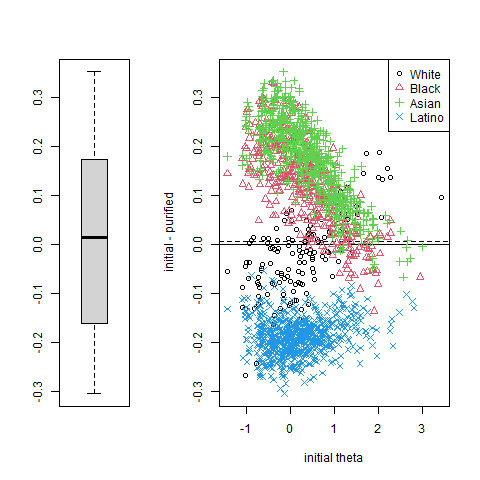

In [6]:
%%R
plot(cdiDIF, labels = c("White", "Black", "Asian", "Latino"))


**Note. The `plot()` function for `lordif`objects only outputs the very last plot.** If you want to see all the plots, you can use the following code to save all of them into a pdf. If you want to include the plots in your portfolio follow this work-around: (1) Run the code chunk in a separate python/.ipynb script (adapted to your dataset) (2) Save the pdf to a convenient location (3) Use screenshots to export the plot as a .png (4) insert the .png file in you RMD.

In [ ]:
# Save all lordif plots to a PDF in a specified folder (e.g., "figures")
output_path = "your/folder/location/cdiDIF_allplots.pdf"
ro.r(f'pdf("{output_path}")')
ro.r('plot(cdiDIF, labels = c("White", "Black", "Asian", "Latino"))') # Change plotting command as needed
ro.r('dev.off()')

print(f"All plots saved to {output_path}")

All plots saved to L:/Desktop/Main/Classes/psy126/book/TT/9_Invariance/figures/cdiDIF_allplots.pdf


Let us print out the GRM parameters (discrimination, category boundaries) for
the six non-DIF items (non-DIF) and the first DIF item (I2):

In [17]:
GRM = ro.r("cdiDIF$ipar.sparse")
print(GRM.head(10))

            a       cb1      cb2
I1   2.055572 1.5197578       NA
I9   1.942808 1.6169260       NA
I12  1.224337 0.3175138 2.674436
I15  1.424712 1.1699027 2.507799
I19  2.107288 1.1153563       NA
I21  1.129338 1.9135221       NA
I2.1 1.638530 0.9251430       NA
I2.2 1.564181 0.9395047       NA
I2.3 1.611274 0.5323336       NA
I2.4 1.987255 1.0579461       NA



Note that for some items, there is only one category boundary. This results from
the fact that there were not enough observations in a particular category (here,
category 2) for parameter estimation. For such cases, `lordif` collapses categories
automatically. Item 2 was flagged as DIF. We get four sets of discrimination/boundary
parameters, one of each race category.  

The calibrated, group-specific person parameter vector can be extracted using:

In [18]:
ro.r("ppar <- cdiDIF$calib.sparse$theta")

And then we can have a quick histogram to see the distribution of the person parameters in our dataset:

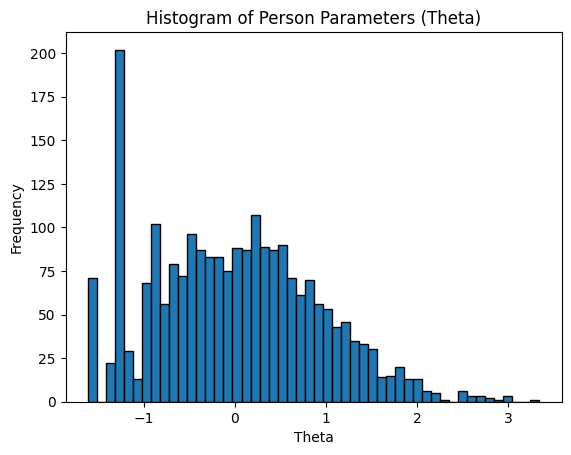

In [20]:
# Bring ppar into Python
ppar = ro.r("ppar")

# Plot histogram
plt.hist(ppar, bins=50, edgecolor='black')
plt.xlabel("Theta")
plt.ylabel("Frequency")
plt.title("Histogram of Person Parameters (Theta)")
plt.show()

Based on the DIF subgroup structure, they are fairly scored, are on the same
scale, and can be subject to further analysis.